In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes

In [6]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 500

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [7]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [8]:
lp.read_data('/home/slaskina/simulations')
#lp.normalize_inputs()

In [5]:
lp.update_hyperparameters( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [6]:
lp.create_loaders()

In [9]:
class ForwardScatteringResNet(nn.Module):
    def __init__(self, N_blocks, ResNet_block) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.resnet_blocks = ResNet_block
        self.res_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU()
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.activation = nn.ELU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            residual = x
            for _ in range(self.resnet_blocks):
                x =  self.res_block(x)
            x += residual
            x = self.activation(x)

        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)
resnet_model = ForwardScatteringResNet(4,3)

In [8]:
lp.set_model(resnet_model)
lp.set_optimizer()

In [9]:
lp.train()

Epoch 0: training loss: 23.766136378776736, test loss: 23.225578722746477
Epoch 1: training loss: 23.334231120784107, test loss: 22.68950951617697
Epoch 2: training loss: 22.783396325460295, test loss: 22.54991672350013
Epoch 3: training loss: 22.355029175921185, test loss: 22.18807029724121
Epoch 4: training loss: 22.28439663677681, test loss: 22.329379703687586
Epoch 5: training loss: 22.34652384316049, test loss: 21.90209662395975
Epoch 6: training loss: 22.249917007074124, test loss: 21.943618276844855
Epoch 7: training loss: 22.269742337668813, test loss: 22.00197228141453
Epoch 8: training loss: 22.16117340180932, test loss: 21.989127864008363
Epoch 9: training loss: 22.131334397850967, test loss: 22.027248299640156
Epoch 10: training loss: 22.33611520906774, test loss: 21.95899241903554
Epoch 11: training loss: 22.281850745038287, test loss: 22.031891034997027
Epoch 12: training loss: 22.293877392280393, test loss: 22.104247881018598
Epoch 13: training loss: 22.22078014001614, t

In [10]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

Accuracy is 41.30%
MSE for radius per shape for correctly identified instances as follows: sphere: 53.7327, hardsphere: 10.1912 and cylinder: 11.6384
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 622427.6250, hardsphere: 33.7911 and cylinder: 75141.1250
MSE for cylinder length for correctly identified instances: 340.7345
MSE for cylinder length polydispersity for correctly identified instances: 16357.8760
MSE for cylinder length for correctly identified instances: 49.4317


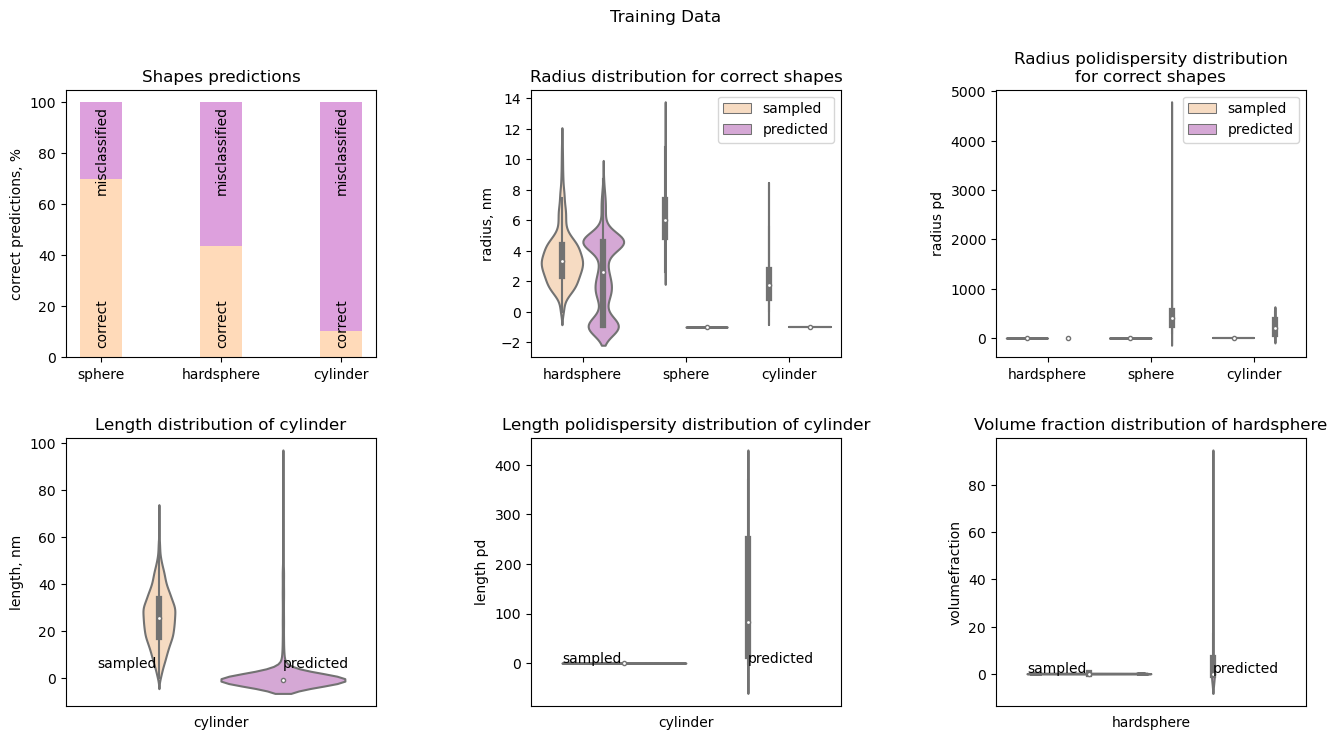

In [11]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 43.07%
MSE for radius per shape for correctly identified instances as follows: sphere: 55.7426, hardsphere: 10.9345 and cylinder: 12.3128
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 797765.1250, hardsphere: 39.6064 and cylinder: 75766.0859
MSE for cylinder length for correctly identified instances: 342.7174
MSE for cylinder length polydispersity for correctly identified instances: 15403.5518
MSE for cylinder length for correctly identified instances: 60.3439


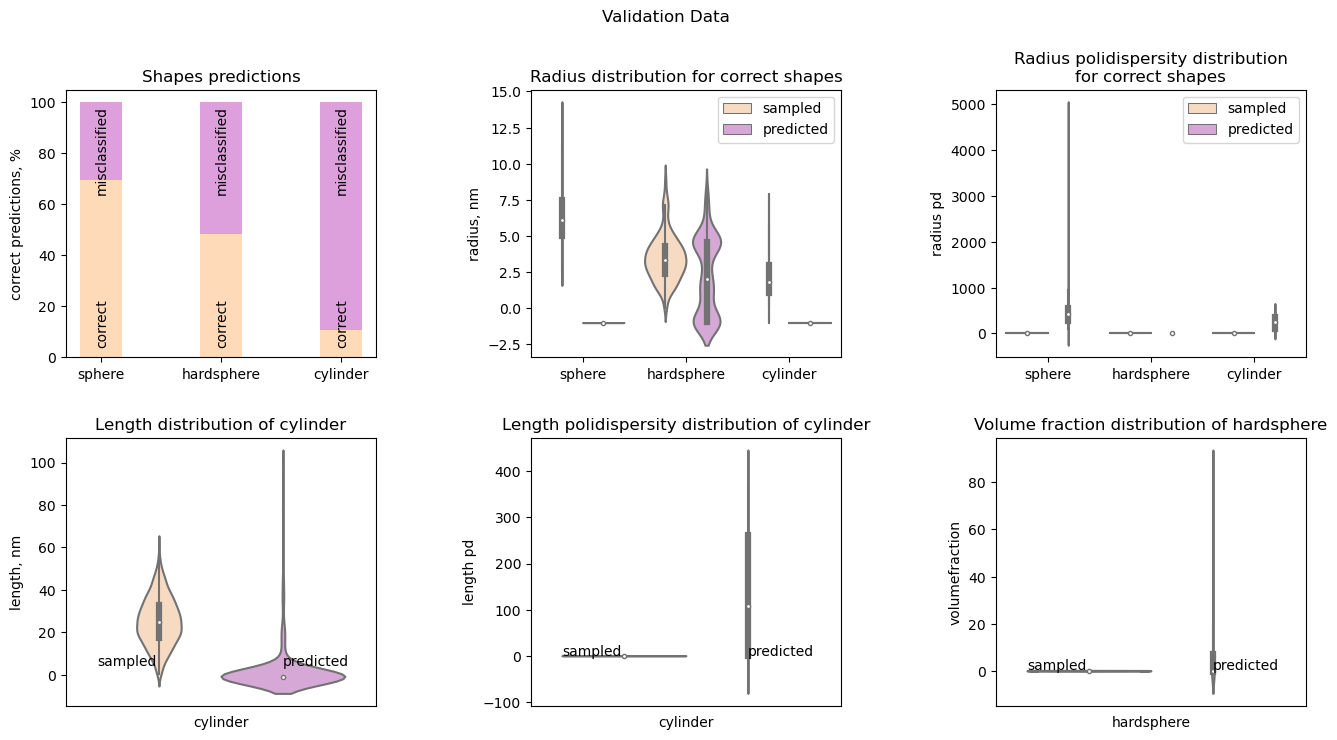

In [12]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 39.67%
MSE for radius per shape for correctly identified instances as follows: sphere: 52.0440, hardsphere: 9.8439 and cylinder: 15.3857
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 589094.8125, hardsphere: 31.0874 and cylinder: 95976.3203
MSE for cylinder length for correctly identified instances: 245.5405
MSE for cylinder length polydispersity for correctly identified instances: 21657.1953
MSE for cylinder length for correctly identified instances: 42.5309


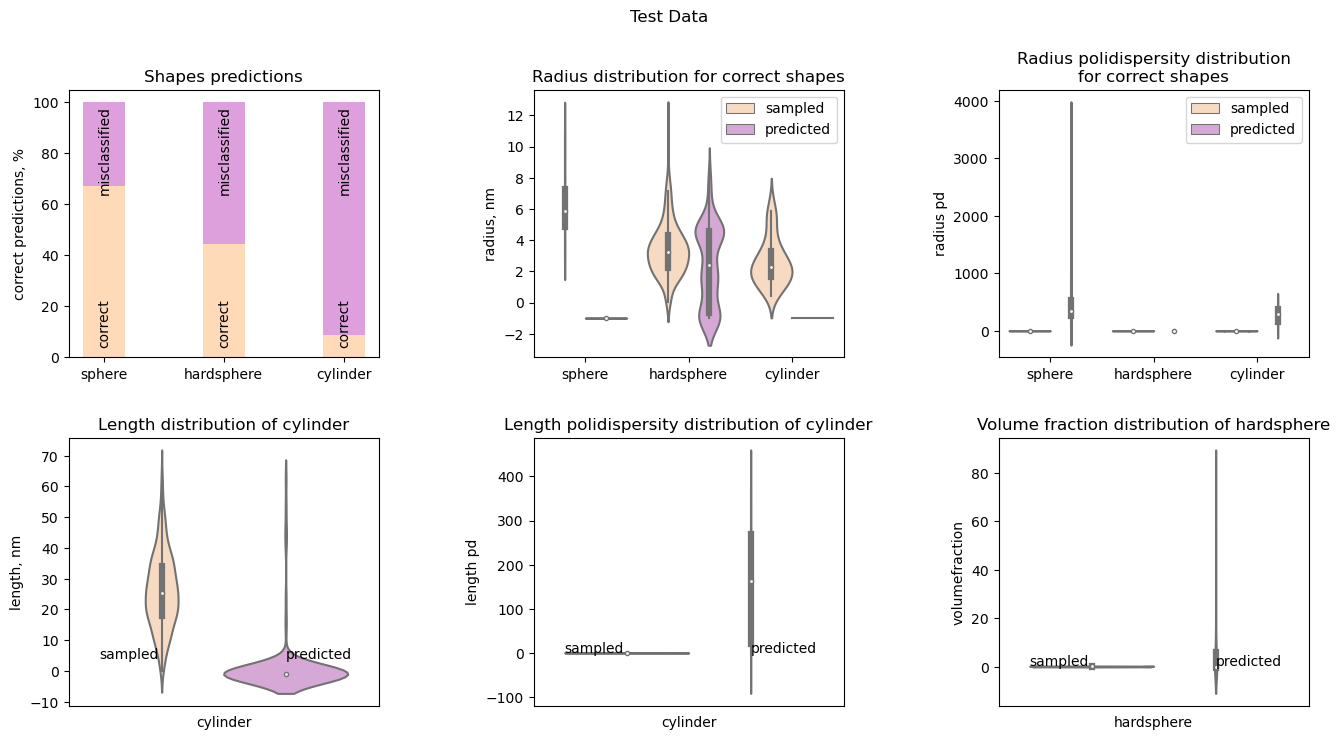

In [13]:
plot_outcomes_identified(df_test, 'Test')

In [14]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,0,4.521623,-0.999962,0.137957,24.569065,0.000000,-0.030994,0.000000,14.335946,0.20,32.620216
1,2,0,7.016451,-1.000000,0.110119,628.237671,15.069812,-1.000000,0.166154,-1.000000,0.00,-1.000000
2,2,0,6.242439,-1.000000,0.104703,1470.087891,23.140541,738.428833,0.257852,-1.000000,0.00,1362.789673
3,2,0,8.598413,-1.000000,0.146229,859.467896,10.450610,-1.000000,0.118462,-1.000000,0.00,313.424683
4,1,2,5.372845,-1.000000,0.139639,29.578743,0.000000,-1.000000,0.000000,21.518425,0.05,4.554488
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,0.215263,0.070455,0.103530,0.064043,0.000000,0.001619,0.000000,-0.013537,0.30,0.065174
1496,0,0,7.928937,-1.000000,0.070772,292.002716,0.000000,-1.000000,0.000000,-1.000000,0.00,-1.000000
1497,2,0,2.721311,-1.000000,0.158766,519.550964,34.106861,248.440048,0.126336,-1.000000,0.00,-1.000000
1498,0,0,6.885484,-1.000000,0.064197,291.937073,0.000000,-1.000000,0.000000,176.904816,0.00,-1.000000


In [10]:
filename_out    = 'output/ff_nn_resnet_norm.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 500

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [11]:
lp.normalize_inputs()

In [12]:
lp.update_hyperparameters( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [13]:
lp.create_loaders()
lp.set_model(resnet_model)
lp.set_optimizer()

In [14]:
lp.train()

Epoch 0: training loss: 23.28441224447111, test loss: 22.750278970469598
Epoch 1: training loss: 23.056148017325054, test loss: 22.574041698289953
Epoch 2: training loss: 22.534065432664825, test loss: 22.16903885551121
Epoch 3: training loss: 22.467400318238795, test loss: 22.402937930563223
Epoch 4: training loss: 26.94776153564453, test loss: 22.220054709393047
Epoch 5: training loss: 22.25888619771818, test loss: 22.08958857992421
Epoch 6: training loss: 22.289031610256288, test loss: 22.08019497083581
Epoch 7: training loss: 22.374232548039135, test loss: 22.23092974787173
Epoch 8: training loss: 22.343022881484615, test loss: 21.95240194901176
Epoch 9: training loss: 22.228042532758014, test loss: 21.980059913966965
Epoch 10: training loss: 22.32471442804104, test loss: 21.90145666702934
Epoch 11: training loss: 22.16095680143775, test loss: 22.13032341003418
Epoch 12: training loss: 22.33872292681438, test loss: 21.933157547660496
Epoch 13: training loss: 22.32260976186613, test

In [15]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

Accuracy is 49.07%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 409.9051 and cylinder: 14.9385
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0892 and cylinder: 1.1960
MSE for cylinder length for correctly identified instances: 697.8364
MSE for cylinder length polydispersity for correctly identified instances: 0.1099
MSE for cylinder length for correctly identified instances: 1.1731


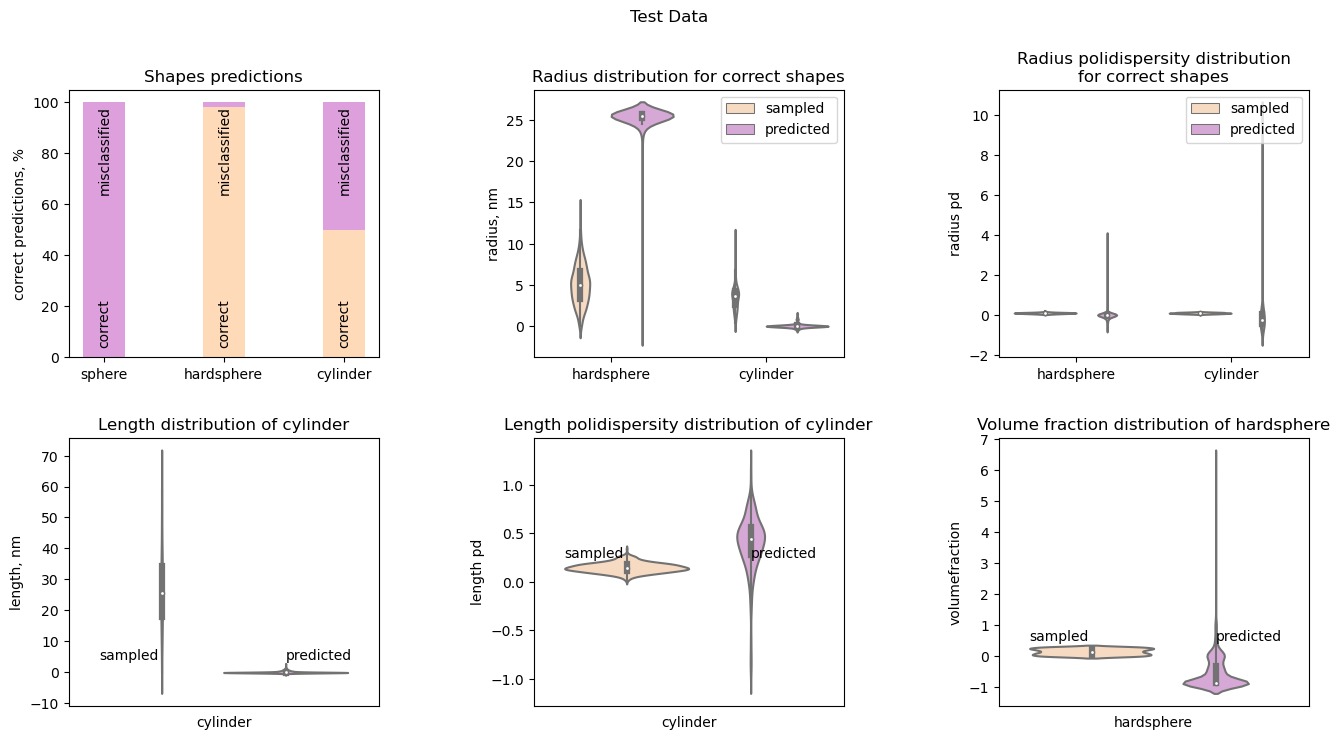

In [16]:
plot_outcomes_identified(df_test, 'Test')